<a href="https://colab.research.google.com/github/AfraAd/CSC413-Homeworks/blob/main/Fall25_Hw11_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 11 - Variational AutoEncoders
CSC413/2516: Neural Networks and Deep Learning

As with previous homeworks, replace "#### Your Code ####" lines with your implementation.

In this homework you will implement and train a Beta-Variational Autoencoder ($\beta$-VAE) on a synthetic dataset we created
1. Implement and train a SimpleVAE (that has Linear layers only)
2. Implement Convolutional $\beta$-VAE (ConvVAE).


Similar to Hw10, you have more freedom in this homework. We will not run your training loop, or test your `Trainer` class, they are there as an initial guidance. We will instead evaluate your predictions, run your model on a test set to make sure. Make use of a gpu on Colab.

# Set-up

In [1]:
import random
from typing import Literal, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

from datasets import load_dataset

SEED = 42


def set_seed():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)


set_seed()

In [2]:
################## HELPER CODE FOR SAVING RELEVANT FILES ##################
if __name__ == "__main__":

    def in_colab():
        try:
            import google.colab

            return True
        except ImportError:
            return False

    if in_colab():
        from google.colab import drive

        drive.mount("/content/drive")
        SAVE_PATH = "/content/drive/MyDrive/CSC413"
    else:
        SAVE_PATH = "."


Mounted at /content/drive


## Explore the Dataset
don't change

In [3]:
class ParametricShapesDataset(Dataset):
    def __init__(
        self, dataset_path, split: Literal["train", "test", "validation"] = "train"
    ):
        self.dataset = load_dataset(dataset_path)[split]

    def __len__(self):
        return len(self.dataset)

    @property
    def input_dim(self):
        return self.dataset[0]["image"].size[0]

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # 2. Permute to PyTorch standard (Channels, Height, Width)
        image_np = np.array(item["image"])
        image = torch.tensor(image_np).permute(2, 0, 1).float() / 255.0
        return {
            "inputs": image,
            "targets": item["shape_type"],
            "shape_name": item["shape_name"],
            "pos_x": item["pos_x"],
            "pos_y": item["pos_y"],
            "size": item["size"],
            "rotation": item["rotation"],
            "id": item["id"],
        }


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/134k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/133k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

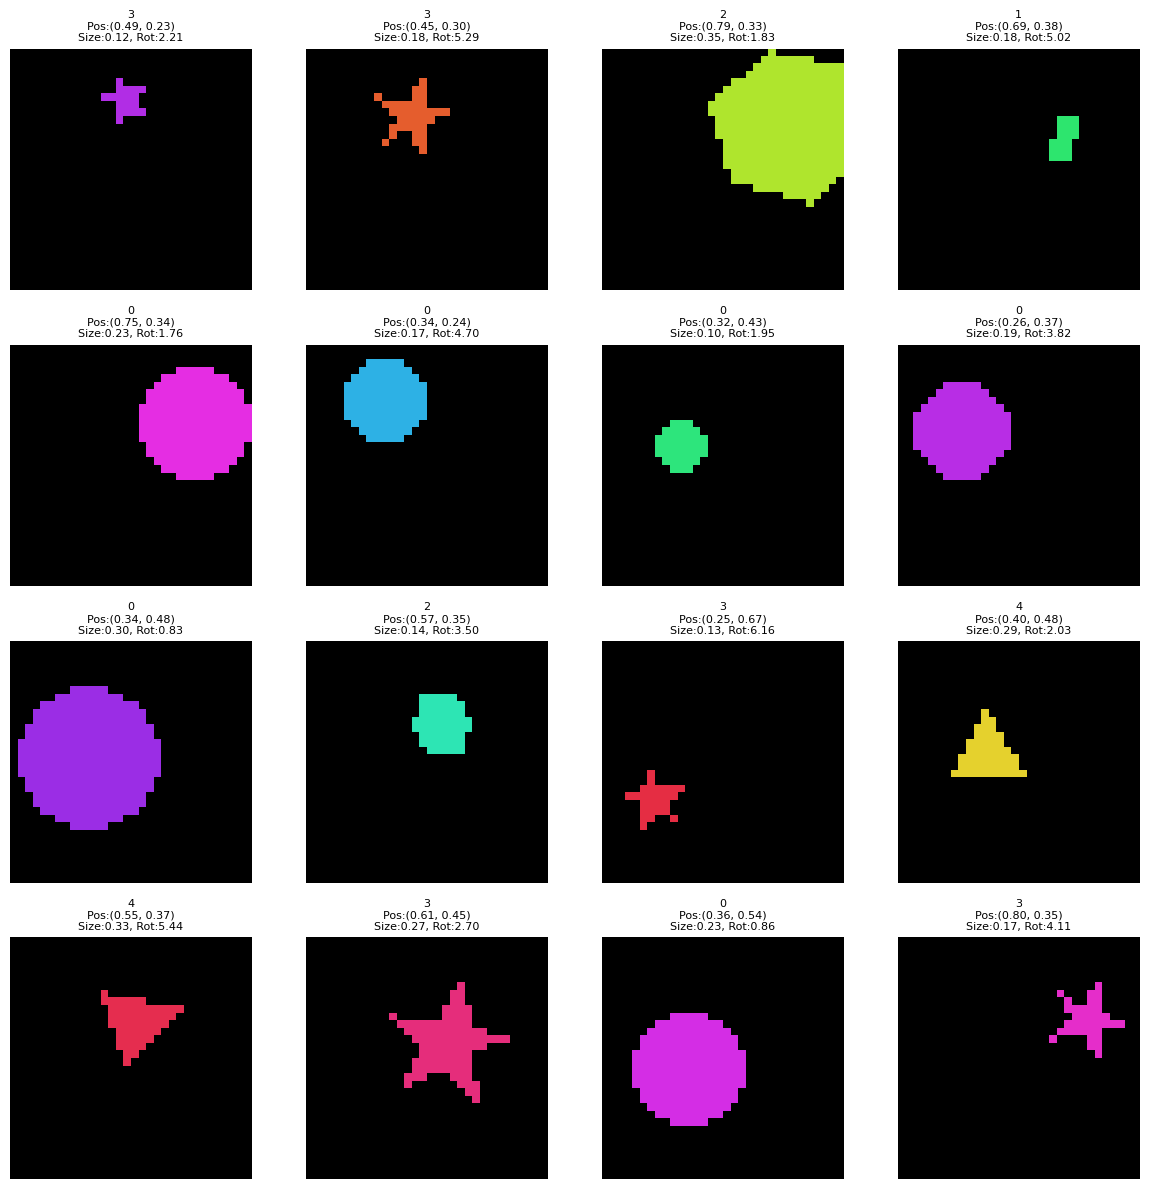

In [4]:
def visualize_samples(
    dataloader, num_samples: int = 16, figsize: Tuple[int, int] = (12, 12)
):
    """Visualize random samples from the dataset."""
    rows = int(np.sqrt(num_samples))
    cols = (num_samples + rows - 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if num_samples > 1 else [axes]

    # Collect enough samples from the dataloader
    collected_samples = []
    data_iter = iter(dataloader)

    while len(collected_samples) < num_samples:
        try:
            batch = next(data_iter)
            batch_size = batch["inputs"].shape[0]

            # Unpack the batch into individual items
            for i in range(batch_size):
                if len(collected_samples) >= num_samples:
                    break

                sample = {
                    "img": batch["inputs"][i],
                    "shape_name": batch["shape_name"][i],
                    "pos_x": batch["pos_x"][i],
                    "pos_y": batch["pos_y"][i],
                    "size": batch["size"][i],
                    "rotation": batch["rotation"][i],
                }
                collected_samples.append(sample)
        except StopIteration:
            break

    # Plotting Loop
    for i, sample in enumerate(collected_samples):
        img = sample["img"]

        # Convert tensor (C, H, W) to (H, W, C)
        img_display = img.permute(1, 2, 0).numpy()

        axes[i].imshow(img_display)
        axes[i].axis("off")

        s_name = sample["shape_name"]

        title = f"{s_name}\n"
        title += f"Pos:({sample['pos_x']:.2f}, {sample['pos_y']:.2f})\n"
        title += f"Size:{sample['size']:.2f}, Rot:{sample['rotation']:.2f}"
        axes[i].set_title(title, fontsize=8)

    # Hide unused subplots
    for i in range(len(collected_samples), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    dl = DataLoader(
        ParametricShapesDataset("r-three/parametric-shapes", split="train"),
        batch_size=8,
        shuffle=True,
    )

    visualize_samples(dl, num_samples=16)

In [5]:
@torch.no_grad()
def visualize_reconstructions(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device,
    num_images: int = 10,
    figsize: Tuple[int, int] = (15, 4),
):
    """
    Takes a batch of data, runs it through the VAE, and visualizes the
    original inputs next to their reconstructions.
    """
    model.eval()

    # 1. Get a single batch of data
    data = next(iter(dataloader))["inputs"]
    # Ensure we don't try to plot more images than are in the batch
    num_to_plot = min(num_images, data.size(0))
    data = data.to(device)[:num_to_plot]

    # 2. Forward Pass: Get Reconstruction
    recon, _, _ = model(data)
    #  (N, H, W, C) for plotting
    original_images = data.cpu().permute(0, 2, 3, 1).numpy()
    reconstructed_images = recon.cpu().permute(0, 2, 3, 1).numpy()

    # 3. Setup Plot Grid (2 rows: Original\\ Reconstruction)
    fig, axes = plt.subplots(2, num_to_plot, figsize=figsize)
    fig.suptitle(
        f"Originals vs. Reconstructions (VAE Latent Dim: {model.fc_mu.out_features})",
        fontsize=14,
    )

    for i in range(num_to_plot):
        # Plot Originals
        ax_orig = axes[0, i]
        ax_orig.imshow(original_images[i], cmap="gray")
        ax_orig.set_title(f"Original {i + 1}", fontsize=9)
        ax_orig.axis("off")

        # Plot Reconstructions
        ax_recon = axes[1, i]
        ax_recon.imshow(reconstructed_images[i], cmap="gray")
        ax_recon.set_title(f"Recon {i + 1}", fontsize=9)
        ax_recon.axis("off")

    # plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()


# Implement the VAE (2 points)
Here implement the reparameterization trick and the VAE loss function. If you wish to play around with the loss function for training, please do so in the subclasses, we will test the `BaseVAE.loss_fn`.

- Reconstruction loss: $$\frac 1 N \sum_i^N \lVert X_i - \hat X_i\rVert_F^2$$
- Unscaled KL divergence penalty: $$KL(q || p)$$, again average per instance

In [6]:
class BaseVAE(nn.Module):
    def __init__(self):
        super(BaseVAE, self).__init__()

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    @staticmethod
    def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """Reparameterization trick to sample from N(mu, var) from
        N(0,1)."""
        z = torch.zeros_like(mu)
        ########################### YOUR CODE ###################################
        ## TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mu)
        z = mu + std * eps
        #########################################################################
        return z

    def forward(
        self, x: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        raise NotImplementedError

    @staticmethod
    def loss_fn(
        x: torch.Tensor,
        x_recon: torch.Tensor,
        mu: torch.Tensor,
        logvar: torch.Tensor,
        beta: float = 1.0,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Computes the VAE loss function.
        The Evidence Lower Bound (ELBO) Loss for VAE.
        Loss = Reconstruction Loss + KL Divergence Loss
        Should return total_loss, recon_loss, kl_loss"""
        total_loss = torch.tensor(0.0)
        recon_loss = torch.tensor(0.0)
        kl_loss = torch.tensor(0.0) # this is prior to scaling
        ########################### YOUR CODE ###################################
        # TODO: 1. Compute reconstruction Loss (MSE), should be averaged over batch dimension (no pixel-level averaging)
        # TODO: 2. KL Divergence Loss (Unscaled), Hint: make sure your KL term includes the negative here
        # HINT: Use the analytical formula, averaged over batch dimension
        batch_size = x.size(0)
        recon_loss = (x_recon - x) ** 2
        recon_loss = recon_loss.view(batch_size, -1).sum(dim=1).mean()

        kl_per_sample = -0.5 * torch.sum(
            1 + logvar - mu.pow(2) - logvar.exp(), dim=1
        )
        kl_loss = kl_per_sample.mean()

        total_loss = recon_loss + beta * kl_loss
        #########################################################################
        return total_loss, recon_loss, kl_loss


In [7]:
class SimpleVAE(BaseVAE):
    def __init__(self, input_dim: int, hidden_dim, latent_dim):
        super(SimpleVAE, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        ########################### YOUR CODE ###################################
        ### TODO: Encoder
        ## 1. Define the encoder layers (these should all be Linear layers or LeakyReLU act)
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.act1 = nn.LeakyReLU()
        ### Decoder
        self.decoder_1 = nn.Linear(latent_dim, hidden_dim)
        self.act2 = nn.LeakyReLU()
        self.decoder_2 = nn.Linear(hidden_dim, input_dim)
        self.act3 = nn.Sigmoid()
        #########################################################################

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Encodes the input by passing through the encoder network
        and returns the latent codes (mean and log variance of q(z|X))."""
        mu = torch.zeros(self.latent_dim)
        logvar = torch.zeros(self.latent_dim)
        ########################### YOUR CODE ###################################
        ## TODO: Implement the encode function
        h = self.encoder(x)
        h = self.act1(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        #########################################################################
        return mu, logvar

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Maps the given latent codes onto the image space (still flattened)."""
        x_recon = torch.zeros(z.size(0), self.input_dim)
        ########################### YOUR CODE ###################################
        ## TODO: Implement the decode function
        h = self.decoder_1(z)
        h = self.act2(h)
        x_recon = self.decoder_2(h)
        x_recon = self.act3(x_recon)
        #########################################################################
        return x_recon

    def forward(
        self, x: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass through the network. Returns the reconstructed
        image along with the latent codes."""
        # No need to change this code
        orig_shape = x.shape
        x = x.flatten(start_dim=1)
        x_recon = x.clone()
        mu = torch.zeros(orig_shape[0], self.latent_dim)
        logvar = torch.zeros(orig_shape[0], self.latent_dim)
        ## 1. Encode to hidden state (Hint: use self.encode)
        ## 2. Reparameterize to get latent code (Hint: use self.reparameterize)
        ## 3. Decode to get reconstructed image (Hint: use self.decode)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        x_recon = x_recon.view(orig_shape)
        return x_recon, mu, logvar


## Implement the Trainer Class (Ungraded)
Implement the trainer.fit function, this should be quite similar to Hw 6, 7, and 9 trainer with a small tweak for loss calculation. You are free to change inner functionality, loss computation, etc. as we won't call the Trainer class.


In [11]:
class Trainer:
    def __init__(
        self,
        max_epochs,
        batch_size,
        gradient_clip_val=1,
        device="cpu",
        print_every: int = 1,
    ):
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.gradient_clip_val = gradient_clip_val
        self.device = device
        self.train_metrics = {"total_loss": [], "recon_loss": [], "kl_loss": []}
        self.valid_metrics = {"total_loss": [], "recon_loss": [], "kl_loss": []}
        self.print_every = print_every

    @staticmethod
    def clip_gradients(model, max_norm):
        if not max_norm:
            return
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

    def get_dataloader(self, data, batch_size=None, shuffle=True):
        g = torch.Generator()
        g.manual_seed(SEED)
        if batch_size is None:
            batch_size = self.batch_size
        loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, generator=g)
        return loader

    def fit(self, model, train_data, val_data, optimizer=None, beta=1.0):
        print("Starting training...")
        print(
            f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.2f} million trainable parameters."
        )
        model.to(self.device)
        if optimizer is None:
            optimizer = torch.optim.SGD(model.parameters(), lr=model.lr)
        train_loader, valid_loader = (
            self.get_dataloader(train_data),
            self.get_dataloader(val_data),
        )

        for epoch in range(self.max_epochs):
            model.train()
            train_loss = 0
            train_mse_loss, train_kl_loss = 0, 0
            valid_loss = 0
            val_mse_loss, val_kl_loss = 0, 0
            ########################### YOUR CODE ###################################
            # TODO: Train the model for max_epochs
            # Complete a single forward and backward pass on a given training batch
            # Record the training losses
            for batch in train_loader:
                X = batch["inputs"].to(self.device)
                x_recon, mu, logvar = model(X)
                total_loss, recon_loss, kl_loss = model.loss_fn(
                    X, x_recon, mu, logvar, beta=beta
                )
                optimizer.zero_grad()
                total_loss.backward()
                self.clip_gradients(model, self.gradient_clip_val)
                optimizer.step()
                train_loss += total_loss.item()
                train_mse_loss += recon_loss.item()
                train_kl_loss += kl_loss.item()
            ########################################################################
            self.train_metrics["total_loss"].append(train_loss / len(train_loader))
            self.train_metrics["recon_loss"].append(train_mse_loss / len(train_loader))
            self.train_metrics["kl_loss"].append(train_kl_loss / len(train_loader))

            model.eval()
            with torch.no_grad():
                ########################### YOUR CODE ###################################
                # TODO: at the end of each epoch, evaluate the model on the validation set.
                # Complete a single forward pass on a given validation batch
                # Record the validation loss
                for batch in valid_loader:
                    X = batch["inputs"].to(self.device)
                    x_recon, mu, logvar = model(X)
                    total_loss, recon_loss, kl_loss = model.loss_fn(
                        X, x_recon, mu, logvar, beta=beta
                    )
                    valid_loss += total_loss.item()
                    val_mse_loss += recon_loss.item()
                    val_kl_loss += kl_loss.item()
                ########################################################################
            self.valid_metrics["total_loss"].append(valid_loss / len(valid_loader))
            self.valid_metrics["recon_loss"].append(val_mse_loss / len(valid_loader))
            self.valid_metrics["kl_loss"].append(val_kl_loss / len(valid_loader))

            if (epoch + 1) % self.print_every == 0:
                print(
                    f"Epoch {epoch + 1} train loss: {self.train_metrics['total_loss'][-1]:.5f},\t train recon loss: {self.train_metrics['recon_loss'][-1]:.5f}, train kl loss: {self.train_metrics['kl_loss'][-1]:.5f}\n\tvalidation loss {self.valid_metrics['total_loss'][-1]:.5f}, val recon loss: {self.valid_metrics['recon_loss'][-1]:.5f}, val kl loss: {self.valid_metrics['kl_loss'][-1]:.5f} "
                )

    def plot_metrics(self):
        """Plot training and validation metrics."""
        epochs = range(1, len(self.train_metrics["total_loss"])+1)

        plt.figure(figsize=(15, 5))

        # Total Loss
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.train_metrics["total_loss"], label="Train Total Loss")
        plt.plot(epochs, self.valid_metrics["total_loss"], label="Valid Total Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Total Loss")
        plt.title("Total Loss over Epochs")
        plt.legend()

        # Reconstruction Loss
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.train_metrics["recon_loss"], label="Train Recon Loss")
        plt.plot(epochs, self.valid_metrics["recon_loss"], label="Valid Recon Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Reconstruction Loss")
        plt.title("Reconstruction Loss over Epochs")
        plt.legend()

        # KL Divergence Loss
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.train_metrics["kl_loss"], label="Train KL Loss")
        plt.plot(epochs, self.valid_metrics["kl_loss"], label="Valid KL Loss")
        plt.xlabel("Epochs")
        plt.ylabel("KL Divergence Loss")
        plt.title("KL Divergence Loss over Epochs")
        plt.legend()

        plt.tight_layout()
        plt.show()

    @torch.no_grad()
    def predict_and_dump(self, model, dataloader, output_path: str):
        """
        Generate predictions on a dataset and dump them to a file.
        Don't change this function.
        """
        model.to(self.device)
        model.eval()

        records = dict()
        for batch in dataloader:
            # Extract batch data
            X = batch["inputs"].to(self.device)
            idx = batch["id"]

            # Get predictions
            x_reconstructed, mu, logvar = model(X)
            for i in range(X.size(0)):
                record = {
                    "id": idx[i].item(),
                    "x_reconstructed": x_reconstructed[i].cpu(),
                    "mu": mu[i].cpu(),
                    "logvar": logvar[i].cpu(),
                }
                records[idx[i].item()] = record
        with open(output_path, "wb") as f:
            torch.save(records, f)
        return records

# Train SimpleVAE (2 points)
Your goal is to achieve <26 MSE reconstruction error on the validation set. You are free to change any args, use another optimizer, add additional tricks, etc.

- You will receive 1.25 points if it is between $26<x<28$
- You will receive 0.75 point if it is between $28<x<30$

Starting training...
Model has 2.40 million trainable parameters.
Epoch 1 train loss: 159.39076,	 train recon loss: 150.73435, train kl loss: 8.65642
	validation loss 92.70532, val recon loss: 90.47030, val kl loss: 2.23502 
Epoch 2 train loss: 84.81465,	 train recon loss: 81.23348, train kl loss: 3.58117
	validation loss 76.37364, val recon loss: 69.86736, val kl loss: 6.50629 
Epoch 3 train loss: 68.62785,	 train recon loss: 60.84839, train kl loss: 7.77946
	validation loss 64.54365, val recon loss: 55.08046, val kl loss: 9.46318 
Epoch 4 train loss: 58.66413,	 train recon loss: 48.24212, train kl loss: 10.42201
	validation loss 56.49574, val recon loss: 44.39114, val kl loss: 12.10460 
Epoch 5 train loss: 52.67879,	 train recon loss: 40.72279, train kl loss: 11.95600
	validation loss 52.64938, val recon loss: 39.91794, val kl loss: 12.73144 
Epoch 6 train loss: 49.87938,	 train recon loss: 37.62779, train kl loss: 12.25159
	validation loss 50.56031, val recon loss: 38.16286, val kl 

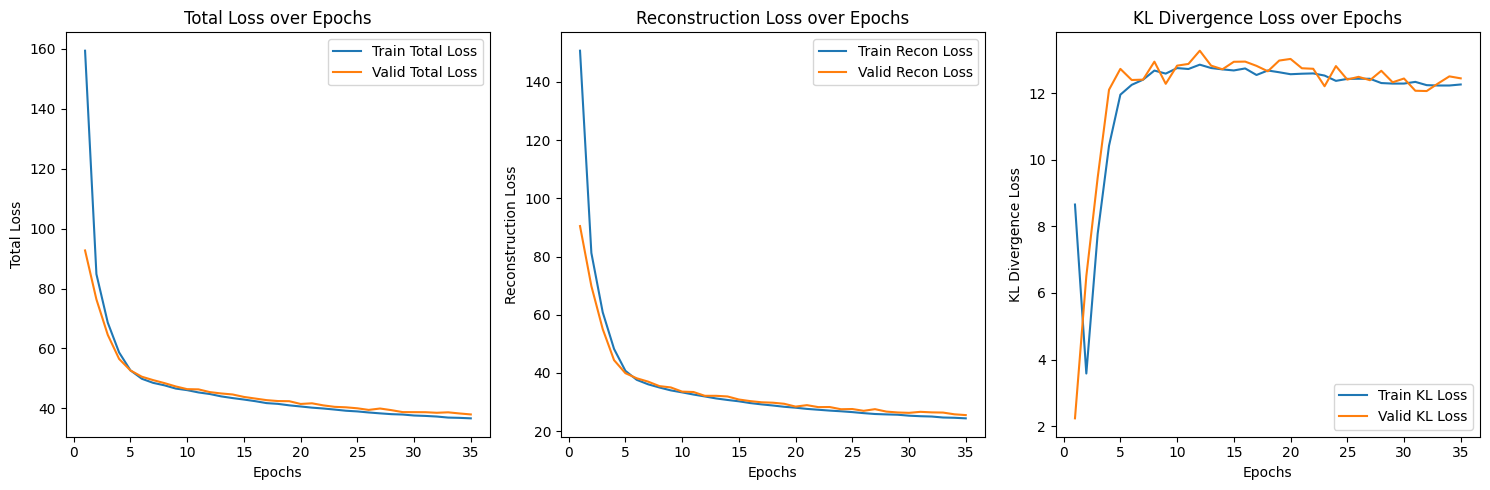

In [9]:
## TODO: Optimize args
args = {
    "hidden_dim": 384,
    "latent_dim": 32,
    "lr": 5e-4,
    "batch_size": 32,
    "num_epochs": 35,
    "gradient_clip_val": 1.0,
    "beta": 0.9,
}

if __name__ == "__main__":
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # Configuration
    train_data = ParametricShapesDataset("r-three/parametric-shapes", split="train")
    val_data = ParametricShapesDataset("r-three/parametric-shapes", split="validation")

    set_seed()
    model = SimpleVAE(
        input_dim=3 * train_data.input_dim * train_data.input_dim,
        hidden_dim=args["hidden_dim"],
        latent_dim=args["latent_dim"],
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

    trainer = Trainer(
        batch_size=args["batch_size"],
        max_epochs=args["num_epochs"],
        gradient_clip_val=args["gradient_clip_val"],
        device=device,
    )

    trainer.fit(model, train_data, val_data, optimizer)
    trainer.plot_metrics()


In [14]:
# if you are happy with the trained model, save it
if __name__ == "__main__":
    torch.save(model.state_dict(), f"{SAVE_PATH}/simple_vae.pth")

In [10]:
if __name__ == "__main__":
    val_loader = trainer.get_dataloader(val_data, batch_size=16, shuffle=False)
    visualize_reconstructions(model, val_loader, device, num_images=10)
    set_seed()
    trainer.predict_and_dump(model, val_loader, f"{SAVE_PATH}/simple-val_predictions.pth")

NameError: name 'trainer' is not defined

*ungraded*

- Does your VAE learn to reconstruct input images?
- Why do we need the reparameterization trick?
- Are there specific classes or input features that the model is struggling with?

## Conv-VAE (2.5 points)
In this part of the homework you will implement a U-NET-like VAE architecture without skip connections, the center of the network is a **stochastic bottleneck** defined by the latent distribution. This architecture is composed of a convolutional encoder and a deconvolutional decoder.

We don't enforce a certain architectural scaffolding, hence you are free to use any architecture (no. of conv layers, non-linearity, etc.), but we will enforce that the architecture contains and calls `nn.Conv2d` and `nn.ConvTranspose2d` layers.

Your goal is to come up with an architecture and optimize hyper-parameters to reach <26 reconstruction loss on the validation set.

In [12]:
class ConvVAE(BaseVAE):
    def __init__(self, hidden_dim, latent_dim):
        super(ConvVAE, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        ########################### YOUR CODE ###################################
        # Assuming input images are 3 x 32 x 32
        self.output_dim = 32

        # ENCODER - Simplified with fewer channels and removed BatchNorm
        self.encoder = nn.Sequential(
            nn.Conv2d(3, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )

        # Flattened conv feature size
        self.conv_out_h = 8
        self.conv_out_w = 8
        self.conv_out_dim = hidden_dim * self.conv_out_h * self.conv_out_w

        # Linear layers for mu and logvar
        self.fc_mu = nn.Linear(self.conv_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.conv_out_dim, latent_dim)

        # DECODER - Simplified
        self.fc_decode = nn.Linear(latent_dim, self.conv_out_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, 3, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.Sigmoid()
        )
        #########################################################################

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Encodes the input image to latent codes (mu and log variance)."""
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Maps the latent code z back to the image space."""
        h = self.fc_decode(z)
        h = h.view(z.size(0), self.hidden_dim, self.conv_out_h, self.conv_out_w)
        x_recon = self.decoder(h)
        return x_recon

    def forward(
        self, x: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass through the network."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

Starting training...
Model has 3.71 million trainable parameters.
Epoch 1 train loss: 506.86100,	 train recon loss: 487.24124, train kl loss: 65.39920
	validation loss 205.94570, val recon loss: 181.70264, val kl loss: 80.81017 
Epoch 2 train loss: 166.83663,	 train recon loss: 147.42628, train kl loss: 64.70118
	validation loss 149.56541, val recon loss: 132.24835, val kl loss: 57.72353 
Epoch 3 train loss: 138.98854,	 train recon loss: 122.57990, train kl loss: 54.69546
	validation loss 129.30364, val recon loss: 113.03596, val kl loss: 54.22560 
Epoch 4 train loss: 121.44349,	 train recon loss: 105.90583, train kl loss: 51.79218
	validation loss 115.81268, val recon loss: 100.76838, val kl loss: 50.14768 
Epoch 5 train loss: 111.47770,	 train recon loss: 96.48491, train kl loss: 49.97596
	validation loss 106.88648, val recon loss: 91.88321, val kl loss: 50.01088 
Epoch 6 train loss: 103.78425,	 train recon loss: 89.25732, train kl loss: 48.42310
	validation loss 99.75778, val recon 

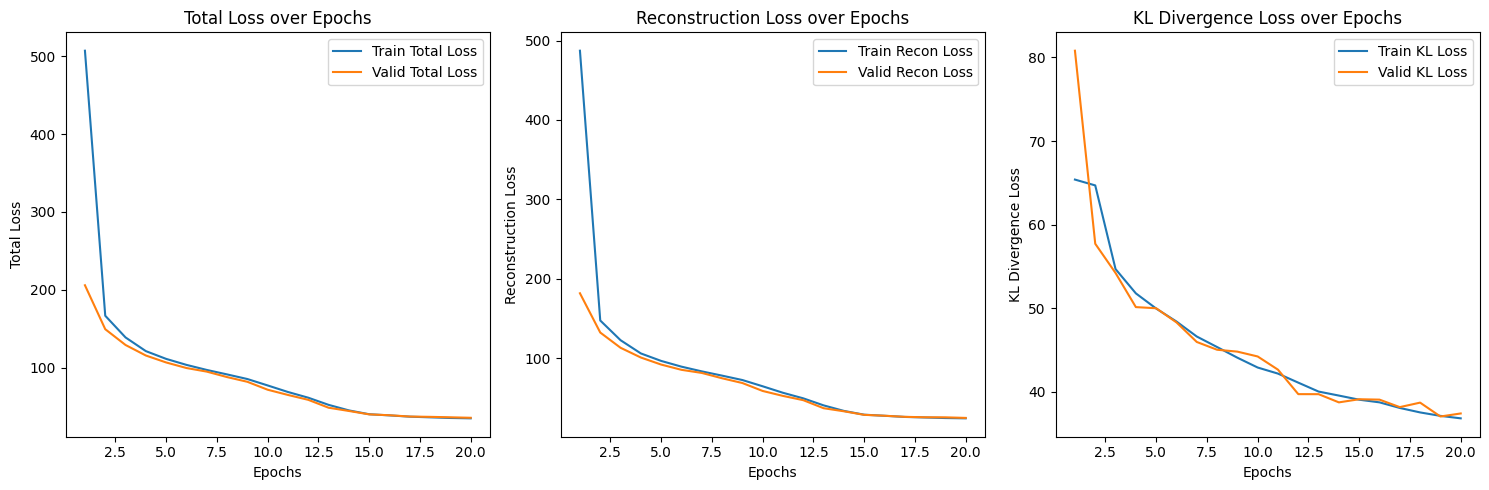

In [15]:
## TODO: Optimize conv args
conv_args = {
    "hidden_dim": 256,
    "latent_dim": 32,
    "lr": 1e-5,
    "batch_size": 32,
    "num_epochs": 20,
    "gradient_clip_val": 1.0,
    "beta": 0.3,
}

if __name__ == "__main__":
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    # Configuration
    set_seed()
    train_data = ParametricShapesDataset("r-three/parametric-shapes", split="train")
    val_data = ParametricShapesDataset("r-three/parametric-shapes", split="validation")
    set_seed()
    model = ConvVAE(
        hidden_dim=conv_args["hidden_dim"],
        latent_dim=conv_args["latent_dim"],
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=conv_args["lr"])

    trainer = Trainer(
        batch_size=conv_args["batch_size"],
        max_epochs=conv_args["num_epochs"],
        gradient_clip_val=conv_args["gradient_clip_val"],
        device=device,
    )

    trainer.fit(model, train_data, val_data, optimizer, beta=conv_args["beta"])
    trainer.plot_metrics()



In [16]:
# if you are happy with the trained model, save it
if __name__ == "__main__":
    state = model.state_dict()
    state_fp16 = {k: v.half() for k, v in state.items()}
    torch.save(state_fp16, f"{SAVE_PATH}/conv_vae_fp16.pth")

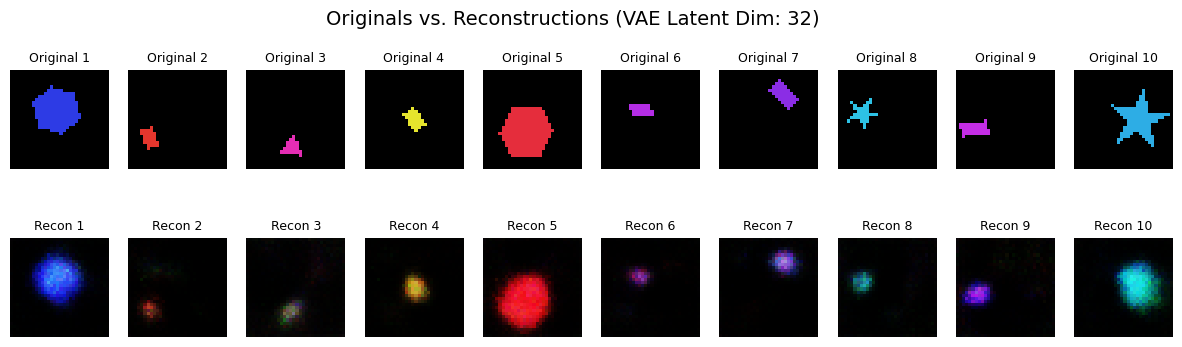

In [17]:
# don't change
if __name__ == "__main__":
    val_loader = trainer.get_dataloader(val_data, batch_size=10, shuffle=False)
    visualize_reconstructions(model, val_loader, device, num_images=10)
    set_seed()
    trainer.predict_and_dump(model, val_loader, f"{SAVE_PATH}/conv-val_predictions.pth")


In the following part, you can look more closely into the latent space of your model. The function below interpolates between the embeddings of two data points in the latent space. Think about the implications of this. Would you have expected it in a vanilla autoencoder setting as well?

In [59]:
@torch.no_grad()
def visualize_interpolation(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device,
    idx_start: int = 0,
    idx_end: int = 1,
    num_steps: int = 8,
    figsize: Tuple[int, int] = (15, 2),
):
    """
    Visualizes the interpolation between the latent codes of two input images.
    """
    model.eval()
    num_to_plot = num_steps + 2  # Start image, num_steps interpolations, End image

    # 1. Get a batch and select the two endpoints
    data = next(iter(dataloader))["inputs"]

    # Select the two images for interpolation
    img_start = data[idx_start].unsqueeze(0).to(device)
    img_end = data[idx_end].unsqueeze(0).to(device)

    # 2. Encode to get latent means (mu)
    mu_start, _ = model.encode(img_start)
    mu_end, _ = model.encode(img_end)

    # 3. Create interpolation path in latent space
    alphas = torch.linspace(0, 1, num_to_plot).to(device).unsqueeze(1)
    # Linear interpolation: z_interp = (1 - alpha) * mu_start + alpha * mu_end
    latent_interpolations = (1 - alphas) * mu_start + alphas * mu_end

    # 4. Decode all interpolated latent vectors
    decoded_images = model.decode(latent_interpolations)
    images_to_plot = decoded_images.permute(0, 2, 3, 1).cpu().numpy()
    # 5. Plotting
    fig, axes = plt.subplots(1, num_to_plot, figsize=figsize)
    fig.suptitle(
        f"Latent Interpolation: $\mathbf{{\mu}}_{{{idx_start}}}$ to $\mathbf{{\mu}}_{{{idx_end}}}$ (Steps={num_steps})",
        fontsize=14,
    )

    for i in range(num_to_plot):
        ax = axes[i]

        ax.imshow(images_to_plot[i].squeeze())
        ax.axis("off")

        if i == 0:
            ax.set_title("Start", fontsize=10)
        elif i == num_to_plot - 1:
            ax.set_title("End", fontsize=10)

    plt.show()


<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-4077675426.py:39: SyntaxWarning: invalid escape sequence '\m'
  f"Latent Interpolation: $\mathbf{{\mu}}_{{{idx_start}}}$ to $\mathbf{{\mu}}_{{{idx_end}}}$ (Steps={num_steps})",
/tmp/ipython-input-4077675426.py:39: SyntaxWarning: invalid escape sequence '\m'
  f"Latent Interpolation: $\mathbf{{\mu}}_{{{idx_start}}}$ to $\mathbf{{\mu}}_{{{idx_end}}}$ (Steps={num_steps})",
/tmp/ipython-input-4077675426.py:39: SyntaxWarning: invalid escape sequence '\m'
  f"Latent Interpolation: $\mathbf{{\mu}}_{{{idx_start}}}$ to $\mathbf{{\mu}}_{{{idx_end}}}$ (Steps={num_steps})",
/tmp

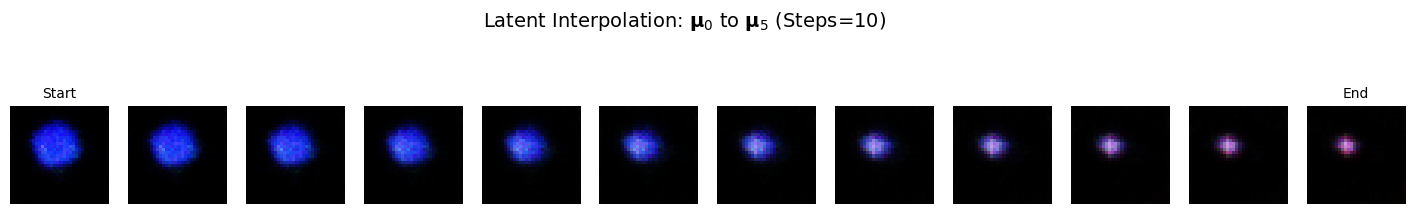

In [60]:
if __name__ == "__main__":
    visualize_interpolation(
        model, val_loader, device, idx_start=0, idx_end=5, num_steps=10, figsize=(18, 3)
    )